# Characterizing Good Advice - Phase 3

### Team Name: Team 3
### Team Members: Wen Yi Aw, Walker Azam, Ken Masumoto

One of our research questions for this project is "What are the qualitites of 'good' advice on career advice subreddits?" To answer this question, we need to analyze the comments on the submissions from our chosen subreddits. We start by importing the necessary libraries and reading in the comment data CSVs from Phase 1.

### Contributions

- Walker
    - Comment data collection
    - Topic Modeling
    - Good Advice characterization data prep
    - Good Advice Naive Bayes Model
- Wen Yi 
    - Submission data collection
    - Good Advice characterization data prep
    - Logistic Regression Model
- Ken 
    - Comment data cleaning
    - Comment data initial analysis
    - Visualizing good advice vs. bad advice
    - Limitations, Ethical Considerations, Future Work, and Takeaways
    
    
### Progress Since Phase 2

Since phase 2, we decided on a measure to characterize "good" advice (75th percentile comment upvote score of each submissions). We used this to create our predictive models for good advice. We created a model using Naive Bayes and a model using Logistic Regression. We also visualized the data and included our final takeaways and lessons. Finally we used hypothesis testing to verify our metric's significances.

## Part 1: Cleaning

We start the cleaning process by importing the necessary libraries and reading in our csv file containing our comment data.

In [1]:
# import necessary packages
import pandas as pd
import re, string

In [2]:
# load data
ask_HR_comments = pd.read_csv("askHR_comments.csv", lineterminator='\n')
career_guidance_comments = pd.read_csv("careerguidance_comments.csv", lineterminator='\n')

# join data files
comments = pd.concat([ask_HR_comments, career_guidance_comments], ignore_index=True)

In [3]:
# data preview
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN


Next, we can run the comment bodies through a preliminary cleaning process, removing links, digits, and punctuation.

In [4]:
def clean1(text):
    """
    Given a text string, removes capitalization, links, numbers, and punctuation. Returns cleaned text string.
    """
    text = text.lower() # make all text to lowercase
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', text) # remove all links
    text = re.sub('\w*\d\w*', '', text) # remove all digits and words containing numbers
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation marks
    text = re.sub('[^A-Za-z ]+', '', text) #remove non-alphabetic characters
    return text

# function to apply clean1 to all entries
cleaner1 = lambda x: clean1(x)

In [5]:
# clean comment body text
comments['cleaned_body'] = pd.DataFrame(comments['body'].apply(cleaner1))

In [6]:
# show cleaned text
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happy for you side note but damn they didnt e...
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,my boss came in a few weeks ago bitching about...
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,let us know how they respond when you give not...
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,did they let you go either way these people ar...
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratulations after you have spent a few m...


Next, we can run the comments' text bodies through an additional round of cleaning by removing the stopwords and stemming each word.

In [7]:
# import necessary packages for stopwords, stemming, tokenizing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# set stopword language
stopeng = set(stopwords.words('english'))
ps = PorterStemmer()

In [8]:
def removeStopAndStem(text):
    """
    Given a text string, removes stopwords and converts words to stems, then returns as one string.
    """
    tokens = word_tokenize(text) # tokenize text
    tokens_nostop = [w for w in tokens if w not in stopeng] # remove stopwords
    tokens_stemmed = [ps.stem(w) for w in tokens_nostop if w != ps.stem(w)] # replace tokens with stems
    text_nostop_stemmed = " ".join([word for word in tokens_stemmed]) # join back to sentence form
    return text_nostop_stemmed

# function to apply removeStopAndStem to all entries
stopRemoverAndStemmer = lambda x: removeStopAndStem(x)

In [9]:
# remove stopwords, then stem comment body text
comments['cleaned_body'] = pd.DataFrame(comments['cleaned_body'].apply(stopRemoverAndStemmer))

In [10]:
# display data
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...


## Part 2: Preliminary Analysis

Now that we have a cleaned, stemmed, and stopword-free version of the comment bodies, we can start to perform some of the analysis on this text. For this preliminary analysis, we decided to collect the following attributes of each comment body:
- Sentiment score (VADER and TextBlob)
- Ratio of stopwords
- Length of post
- Readbility score (Gunning-Fog and Smog)

### Sentiment Score Calculation

We chose to measure sentiment for the comments using VADER and TextBlob. We start by importing the libraries necessary to perform this analysis.

In [11]:
# import packages for sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Then we can save the TextBlob scorer in a lambda function and apply it to all the cleaned rows in the dataframe.

In [12]:
def TextBlobSent(text):
    """
    Given a text string, returns polarity of the text, scored by TextBlob.
    """
    blob = TextBlob(text)
    return blob.polarity

# function to apply TextBlobSent to all entries
TextBlobSentimentizer = lambda x: TextBlobSent(x)

In [13]:
# score cleaned comment text on polarity
comments['TextBlob'] = pd.DataFrame(comments['body'].apply(TextBlobSentimentizer))

We can also add a column to the dataframe that categorizes the comments as "positive," "negative," or "neutral" depending on the TextBlob sentiment score. We know that VADER uses the following thresholds, so we will use the same for the TextBlob scores to control for as much as we can (and because they use the same scale).

- Negative: Score <= -0.05
- Neutral: -0.05 < Score < 0.05
- Positive: Score >= 0.05

In [14]:
def overallScore(compoundscore):
    """
    Given polarity score, returns "positive", "negative", or "neutral" based on the sign of the score
    (with 0.05 buffer).
    """
    if compoundscore > 0.05:
        return "positive"
    elif compoundscore < -0.05:
        return "negative"
    else:
        return "neutral"

# function to apply overallScore to all entries
overallScorer = lambda x: overallScore(x)

In [15]:
# calculate sentiment category of TextBlob scores and store in new column
comments['TextBlob_Category'] = pd.DataFrame(comments['TextBlob'].apply(overallScorer))

We can also do the exact same process, except with the VADER scores this time.

In [16]:
# initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

def VADERSent(text):
    """
    Given text string, returns compound polarity score, calculated using VADER sentiment analysis.
    """
    return analyzer.polarity_scores(text)['compound']

# function to apply VADERSent to all entries
VADERSentimentizer = lambda x: VADERSent(x)

In [17]:
# calculate VADER polarity score of each comment and store in new column
comments['VADER'] = pd.DataFrame(comments['body'].apply(VADERSentimentizer))

In [18]:
# calculate sentiment category of VADER scores and store in new column
comments['VADER_Category'] = pd.DataFrame(comments['VADER'].apply(overallScorer))

And now we can verify that everything has been added correctly.

In [19]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.3182,positive
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive


### Ratio of Stopwords and Length of Post

To find the ratio of stopwords in the post, we have to work with the original body instead of the cleaned body, because the cleaned body has all of the stopwords already removed. We can do this by creating a function that takes in the body of the comment and divides the number of stopwords by the total number of words, then saving this as a lambda function and applying it to all of the rows, as we did with the sentiment analysis above.

In [20]:
def stopwordRatio(text):
    """
    Given text string, returns the ratio of English stopwords to total word count.
    """
    tokens = word_tokenize(text)
    total_words = len(tokens)
    total_stopwords = 0
    # count stopwords
    for token in tokens:
        if token in stopeng:
            total_stopwords += 1
    return total_stopwords / total_words

# function to apply stopwordRatioFinder to all entries
stopwordRatioFinder = lambda x: stopwordRatio(x)

In [21]:
# calculate stopword ratio of each comment and store in new column
comments['stopword_ratio'] = pd.DataFrame(comments['body'].apply(stopwordRatioFinder))

And we can verify that this column has been added correctly.

In [22]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.3182,positive,0.307692
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079


Finding the length of the post is also a very similar process, but instead, we just return the total number of words in the text. Again, we will work with the original body for this.

In [23]:
def textLength(text):
    """
    Given text string, returns word count.
    """
    tokens = word_tokenize(text)
    return len(tokens)

# function to apply textLengthFinder to all entries
textLengthFinder = lambda x: textLength(x)

In [24]:
# calculate stopword ratio of each comment and store in new column
comments['body_length'] = pd.DataFrame(comments['body'].apply(textLengthFinder))

And again, we can verify that this was added correctly.

In [25]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634,41
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182,44
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.3182,positive,0.307692,13
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310,29
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079,63


### Readability Scores

The final variable we chose to include for this part of the analysis was readability scores. We will use the both Gunning-Fog and the Smog Readability Index scores to measure the readability of each comment. Again, we will use the original body for this analysis, as the cleaned body is nonsensical with the stopwords removed and the words stemmed.

In [26]:
import textstat

In [27]:
def smog(text):
    """
    Given text string, returns SMOG readability grade.
    """
    return textstat.smog_index(text.lower())

# function to apply smog calculation function to all entries
smog_finder = lambda x: smog(x)

In [28]:
# calculate SMOG grade of each comment and store in new column
comments['smog_score'] = pd.DataFrame(comments['body'].apply(smog_finder))

In [29]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634,41,7.8
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182,44,7.8
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.3182,positive,0.307692,13,0.0
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310,29,7.8
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079,63,8.8


In [30]:
def gunning_fog(text):
    """
    Given text string, returns Gunning-Fog readability score.
    """
    return textstat.gunning_fog(text.lower())

# function to apply gunning_fog_finder to all entries
gunning_fog_finder = lambda x: gunning_fog(x)

In [31]:
# calculate Gunning Fog score of each comment and store in new column
comments['gunning_fog_score'] = pd.DataFrame(comments['body'].apply(gunning_fog_finder))

And of course, we can verify that these columns have been added correctly!

In [32]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score,gunning_fog_score
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634,41,7.8,5.82
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182,44,7.8,6.23
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.3182,positive,0.307692,13,0.0,4.40
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310,29,7.8,6.52
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079,63,8.8,7.51


## Part 3: Preliminary Visualization and Analysis

We now have a large number of categories to be able analyze to try to find what constitutes "good" advice on advice-giving subreddits. We use the comment score as the measure of "good" advice on the subreddits, and can find correlations between the comment score and the variables of interest. We can easily visualize these correlations using a heat map.

In [33]:
# import visualization libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns

Text(0.5, 1.0, 'Heatmap of Comment Data')

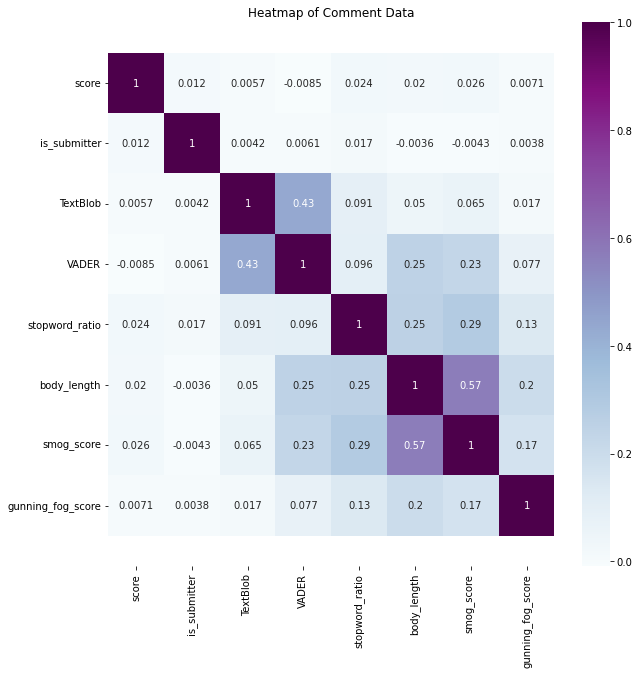

In [34]:
f, ax = plt.subplots(figsize=(10, 10))
# heatmap of correlation between variables
sns.heatmap(comments.drop(['distinguished', 'Unnamed: 0'], axis=1).corr(), ax=ax, annot=True, cmap="BuPu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.title('Heatmap of Comment Data')

Unfortunately, it does not look like any of the correlations between any of the variables and the comment score are particularly strong. However, this is just a preliminary analysis, so we can revisit this later to try to find any stronger relationships.

We can also start to visualize the distributions of some of the variables that we just discovered, to get an overall better understanding of the data.

Text(0.5, 0, 'Upvotes')

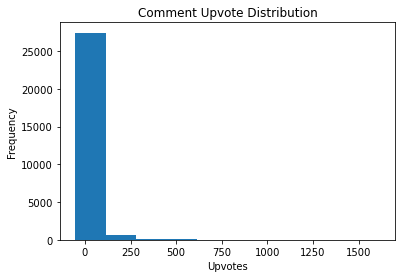

In [35]:
# histogram of upvotes
comments['score'].plot.hist()
plt.title("Comment Upvote Distribution")
plt.xlabel("Upvotes")

This isn't particularly useful, so we will instead graph the histogram of scores under 200.

Text(0.5, 0, 'Score')

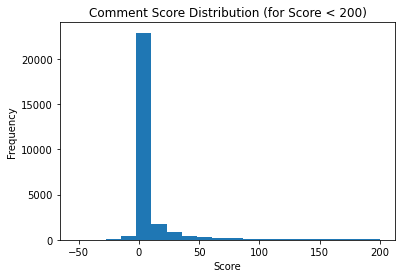

In [36]:
# histogram of upvotes for comments with less than 200 upvotes
comments[comments['score'] <= 200].score.plot.hist(bins=20)
plt.title("Comment Score Distribution (for Score < 200)")
plt.xlabel("Score")

We can see that the scores are relatively normally distributed, with the vast majority of scores being close to 0.

Text(0.5, 0, 'Polarity')

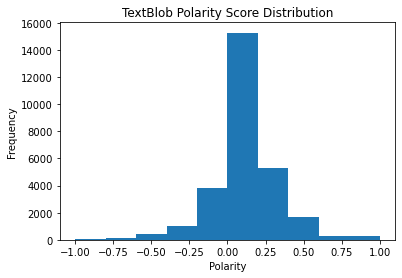

In [37]:
# histogram of TextBlob polarity scores
comments['TextBlob'].plot.hist()
plt.title("TextBlob Polarity Score Distribution")
plt.xlabel("Polarity")

Text(0.5, 0, 'Polarity')

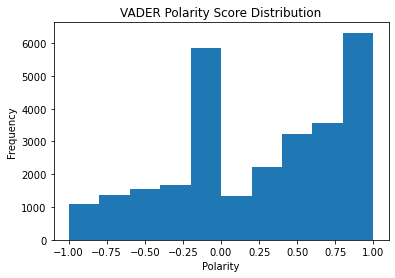

In [38]:
# histogram of VADER polarity scores
comments['VADER'].plot.hist()
plt.title("VADER Polarity Score Distribution")
plt.xlabel("Polarity")

The two sentiment analysis score histograms also give some interesting results. They both center around 0, which makes sense. However, the VADER scores seem to be bimodal (or even trimodal), with additional apexes at -0.5 and 0.5. This may be just the way that VADER tends to score sentiments, or it could be something to delve deeper into. This is something we will explore further in future phases.

Text(0.5, 0, '# stopwords / total words')

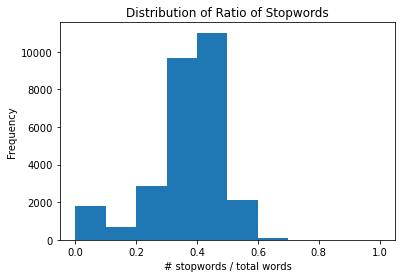

In [39]:
# histogram of stopword ratios
comments['stopword_ratio'].plot.hist()
plt.title("Distribution of Ratio of Stopwords")
plt.xlabel("# stopwords / total words")

The stopword ratio histogram looks relatively normally distributed around 0.4. There isn't much to analyze here, especially since the correlation between stopword ratio and comment score was relatively low.

Text(0.5, 0, 'Word Count')

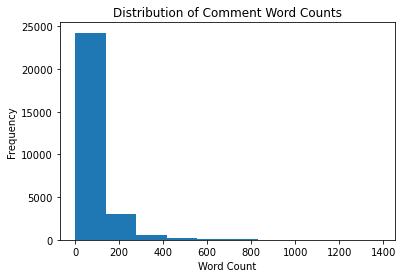

In [40]:
# histogram of comment length
comments['body_length'].plot.hist()
plt.title("Distribution of Comment Word Counts")
plt.xlabel("Word Count")

Text(0.5, 0, 'Word Count')

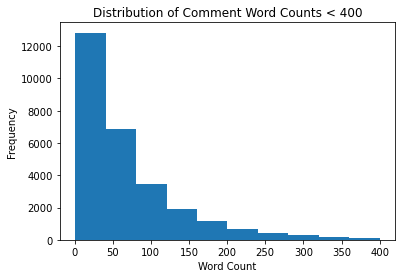

In [41]:
# histogram of comment length, for comments with less than 400 words
comments[comments['body_length']  <= 400].body_length.plot.hist()
plt.title("Distribution of Comment Word Counts < 400")
plt.xlabel("Word Count")

The distribution of comments with word counts is an interesting graph because it is almost a perfect right-skewed distribution. We can see that most of the comments were relatively short, but some were much longer.

Text(0.5, 0, 'SMOG Score')

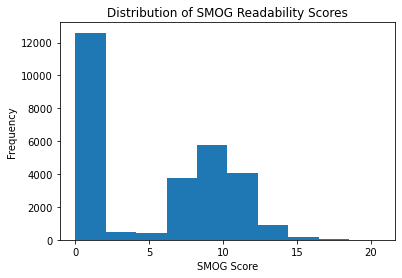

In [42]:
# histogram of SMOG readability scores
comments['smog_score'].plot.hist()
plt.title("Distribution of SMOG Readability Scores")
plt.xlabel("SMOG Score")

Text(0.5, 0, 'Gunning-Fog Score')

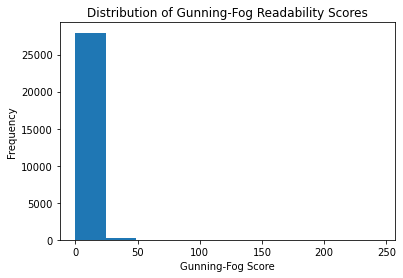

In [43]:
# histogram of Gunning-Fog readability scores
comments['gunning_fog_score'].plot.hist()
plt.title("Distribution of Gunning-Fog Readability Scores")
plt.xlabel("Gunning-Fog Score")

Text(0.5, 0, 'Gunning-Fog Score')

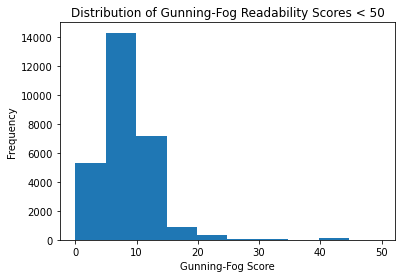

In [44]:
# histogram of Gunning-Fog readability scores under 50
comments[comments['gunning_fog_score'] <= 50].gunning_fog_score.plot.hist()
plt.title("Distribution of Gunning-Fog Readability Scores < 50")
plt.xlabel("Gunning-Fog Score")

For the readability scores, the Gunning-Fog score is somewhat right skewed, with a peak in the range of 5-10 (i.e. a reading level for U.S. grades 5-10). The SMOG score seems at first glance to be more interesting, but this is likely just the way that the Smog score is calculated. It is likely that there is a normal distribution around 8 or 9 (i.e. a reading level for U.S. grades 8-9), with a handful of comments being given a score of 0 because SMOG couldn't accurately score it. This will be something we will look into in future phases, though, just to make sure.

## Part 4: Phase II Conclusions

It was a little bit disappointing to not find any strong correlations between the comment score and the other variables, but in future phases we can still find new variables to compare and also look more deeply into the relationships than a correlation test will allow. However, we did still learn a lot about our data set, which we can iterate on for future phases.

## Part 5: Categorizing Good Advice

A part of the project that was suggested was to establish a baseline for 'good' and 'bad' advice. This is difficult to do by hand since there are over 28,000 comments. Thus, we decided to use a percentile score cut-off to determine good or not-good advice. Using this cut-off, we can create an output column 'good_advice' where 1 = 'good advice', and 0 = 'not good advice'. 

First we are going to figure out what the percentile cut-off is for each submission:

In [45]:
# viewing head
comments.head()
# dropping columns that aren't useful
comments_clean = comments.copy()
comments_clean = comments_clean.drop(['Unnamed: 0', 'distinguished'], axis = 1)
comments_clean.head()

,submission id,comment id,body,score,is_submitter,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score,gunning_fog_score
0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634,41,7.8,5.82
1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182,44,7.8,6.23
2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,notic pleas,0.000000,neutral,0.3182,positive,0.307692,13,0.0,4.40
3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310,29,7.8,6.52
4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079,63,8.8,7.51


We decided that we would group each comment by its original submission post. Then the top 25% of comments with the highest score would be Good Advice, and the rest would be 0:

In [46]:
# group by submission ids:
by_submission = comments_clean.groupby('submission id') #.score.quantile([0.75])
dict_good_advice = dict()
for name, group in by_submission:
    quantile_75 = group.score.quantile([0.75][0])
    # storing each original posts 75th score percentile in a dict
    dict_good_advice[name] = quantile_75

In [47]:
# converting our dictionary into a Dataframe for easier comparing
advice_sep_df = pd.DataFrame.from_dict(dict_good_advice, orient='index', columns=['CutOff'])
advice_sep_df.head()

,CutOff
n9waco,12.00
n9yqap,22.75
n9zbko,9.00
nake8t,8.00
nb8sa0,4.00


Here we have the 75 percentile cutoff for each original submission id. We can now use this to split our comments into whether they are good or not good advice.

In [48]:
# creating a list of whether each comment (row) is good or bad advice
is_good_advice = []
# checking each rows score to the 75th score percentile for that post total comments
for i in range(comments_clean.shape[0]):
    original_submission_id = comments_clean.iloc[i, :]['submission id']
    if comments_clean.iloc[i, :]['score'] > int(advice_sep_df.loc[[original_submission_id], 'CutOff']):
        is_good_advice.append(1)
    else:
        is_good_advice.append(0)

In [49]:
# adding it as a boolean column to comments_clean
comments_clean['good_advice'] = is_good_advice
comments_clean.head(10)

,submission id,comment id,body,score,is_submitter,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score,gunning_fog_score,good_advice
0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,happi theyr go realli awaken tri backfil,0.433333,positive,-0.4478,negative,0.414634,41,7.8,5.82,1
1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,week bitch expens everyth get ask get live rai...,-0.030000,neutral,-0.2023,negative,0.318182,44,7.8,6.23,1
2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,notic pleas,0.000000,neutral,0.3182,positive,0.307692,13,0.0,4.40,1
3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,peopl idiot manag think peopl employ,-0.800000,negative,0.1280,positive,0.379310,29,7.8,6.52,1
4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,congratul month get comfort settl pleas abl co...,0.204040,positive,0.9594,positive,0.365079,63,8.8,7.51,1
5,r0mlaq,hltila8,That’s fantastic! Onward and upward my friend!,11,False,that fantast,0.625000,positive,0.8118,positive,0.272727,11,0.0,8.51,1
6,r0mlaq,hlto0j4,This is the kind of update I like to see! Co...,9,False,updat congrat mani compani mistak victori empl...,0.333333,positive,0.7574,positive,0.372093,43,0.0,10.76,1
7,r0mlaq,hluk2yz,> HR setup a call with me and my manager the n...,10,False,manag expect essenti middl confid compens bene...,0.133333,positive,0.8957,positive,0.397260,73,9.6,8.68,1
8,r0mlaq,hltmlk8,Good bye to bad rubbish! The company I work f...,8,False,compani think salari competit peopl quit inter...,0.158673,positive,-0.3382,negative,0.312500,48,8.1,5.15,0
9,r0mlaq,hlth3gb,Congratulations!!,8,False,congratul,0.000000,neutral,0.6688,positive,0.000000,3,0.0,40.40,0


In the code snippets above we converted the raw 'scores' for each comment into whether is it Good Advice or not. We determined this by categorizing good advice posts that have at least a score above the 75th percentile of all comments for a given post. This means that for each submission we collected, only the top 25% of comments would be 'good advice'. This allows the actual value to scale for each post instead of using a 'cut off' that is the same for all posts. 

It should be admitted that this approach to splitting advice quality is not the most robust. In reality, a post with high upvote scores don't necessarily mean that it is relevant and good advice. A post with many upvotes could be a funny/meme post that is irrelevant to the original question. There is also no professional way to determine how 'good' advice is. That is a limitation of our study. In future studies there could be a human validation aspect to splitting advice.

## Part 6: Data Pre-Processing before Machine Learning

Here we will make sure our data is currently vectorized and all our columns are usable before proceeding to train and testing our models. The models we will use are Naive Bayes (predicting metrics, and bag of words) and Logistic Regression. We are choosing these two ML models since time limitations prevent us from hyper-parameter tuning more complex models like SVM/Neural Network. Naive Bayes also works well with large text data, which would be good for our study. Logistic Regression can help us discern what metrics are more contributing to advice prediction than others.

First let's make a copy of our dataframe with only the columns we will be using in our model:

In [51]:
ml_df = comments_clean.copy()
ml_df = ml_df[['body', 'TextBlob', 'VADER', 'stopword_ratio',
              'body_length', 'smog_score', 'gunning_fog_score', 'good_advice']]
ml_df.head(10)

,body,TextBlob,VADER,stopword_ratio,body_length,smog_score,gunning_fog_score,good_advice
0,"Happy for you. Side note but damn, they didn'...",0.433333,-0.4478,0.414634,41,7.8,5.82,1
1,My boss came in a few weeks ago bitching about...,-0.030000,-0.2023,0.318182,44,7.8,6.23,1
2,Let us know how they respond when you give not...,0.000000,0.3182,0.307692,13,0.0,4.40,1
3,"Did they let you go? Either way, these people ...",-0.800000,0.1280,0.379310,29,7.8,6.52,1
4,Congratulations!! After you have spent a few...,0.204040,0.9594,0.365079,63,8.8,7.51,1
5,That’s fantastic! Onward and upward my friend!,0.625000,0.8118,0.272727,11,0.0,8.51,1
6,This is the kind of update I like to see! Co...,0.333333,0.7574,0.372093,43,0.0,10.76,1
7,> HR setup a call with me and my manager the n...,0.133333,0.8957,0.397260,73,9.6,8.68,1
8,Good bye to bad rubbish! The company I work f...,0.158673,-0.3382,0.312500,48,8.1,5.15,0
9,Congratulations!!,0.000000,0.6688,0.000000,3,0.0,40.40,0


We are including the cleaned text, the sentiment score, and other metrics, along with our category column 'good_advice'. Before we proceed we will pre-process the cleaned text to make sure it matches our LDA processing and uses lemmatizer instead of stemmer:

In [52]:
# saving body text as a series to easily clean
data = ml_df.copy()
data_clean = data.body
# closer look at first element
print("Uncleaned First Element: ",data_clean[0], "\n")

# converting all text to lowercase
data_clean = data_clean.str.lower()
# replace all non-alphanumeric symbols:
data_clean = data_clean.str.replace(r"[^\w\s]", "", regex=True)
# removing new line symbols
data_clean = data_clean.str.replace("\\n", " ", regex=True)
print("More cleaned First Element: ", data_clean[0])

Uncleaned First Element:  Happy for you.  Side note but damn, they didn't even make an attempt lol? They're going to be in for a really rude awakening when they try to hire your backfill in this job market. 

More cleaned First Element:  happy for you  side note but damn they didnt even make an attempt lol theyre going to be in for a really rude awakening when they try to hire your backfill in this job market


In [53]:
# removing stopwords
stop_words = stopwords.words('english')
# also adding variations of existing stopwords, but without ' (i.e: i've = ive)
no_punct = [w.replace("'", "") for w in stop_words if "'" in w]
stop_words.extend(no_punct)
new_stop = ['im', 'ive']
stop_words.extend(new_stop)
# using .apply to apply our function to all rows:
data_clean = data_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [54]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# we can include it while filtering out stop words
data_clean = data_clean.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [55]:
# adding it as a cleaned and lemmatized column to ml_df
ml_df['cleaned_text'] = data_clean
ml_df.head()

,body,TextBlob,VADER,stopword_ratio,body_length,smog_score,gunning_fog_score,good_advice,cleaned_text
0,"Happy for you. Side note but damn, they didn'...",0.433333,-0.4478,0.414634,41,7.8,5.82,1,happy side note damn even make attempt lol the...
1,My boss came in a few weeks ago bitching about...,-0.030000,-0.2023,0.318182,44,7.8,6.23,1,bos came week ago bitching expensive everythin...
2,Let us know how they respond when you give not...,0.000000,0.3182,0.307692,13,0.0,4.40,1,let u know respond give notice please
3,"Did they let you go? Either way, these people ...",-0.800000,0.1280,0.379310,29,7.8,6.52,1,let go either way people idiot management need...
4,Congratulations!! After you have spent a few...,0.204040,0.9594,0.365079,63,8.8,7.51,1,congratulation spent month getting comfortable...


Now that we have cleaned and lemmatized our text, we can proceed to vectorize it, using count vectorizer from sklearn. This will allow us to use it in our machine learning models:

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
# initializing
vectorizer = CountVectorizer()
# fitting to data
vectorizer.fit(data_clean)
# transforming our data:
counts = vectorizer.transform(data_clean)
print("Shape:", counts.shape)

Shape: (28219, 23980)


We can see that across our 28K comments, our vectorized identified ~24,000 unique tokens. This is currently a sparse matrix, but we can convert it to a Dataframe, and attach our other metrics (VADER/TextBlob/stopword_ratio etc...):

In [57]:
vectors_df = pd.DataFrame(counts.toarray(), columns=vectorizer.get_feature_names_out())
print("Shape:", vectors_df.shape)
vectors_df.head()

Shape: (28219, 23980)


,00,000,0000,001,002,007,01,02,020,025mm,...,zoomphone,zoomteams,zoomvideo,zoomvirtual,zooologist,zuckerberg,zzz,în,übermensch,那個
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# attaching out metrics:
for col in ml_df.columns[1:8]:
    vectors_df[col] = ml_df[col]

In [59]:
# seeing our new vector_df shape:
print(vectors_df.shape)

(28219, 23987)


We can see that 8 additional columns were added as expected! We know that 'good_advice' is the label column too. Before we can proceed with modelling, we have to first make decisions on what data to include and how to set up our modelling test/training data.

### Feature/Dataset Curation:

Since we split our dataset into top 25% good advice, currently for every good advice post, there is at least 3 not good advice. We want to make our dataset be more representative of good and bad advice, so we want to normalize the distribution of categories. This has the added benefit of making our training dataset smaller. 

In [60]:
# Lets see the breakdown of value counts
valuecounts = vectors_df['good_advice'].value_counts()
valuecounts

0    21778
1     6441
Name: good_advice, dtype: int64

Currently we have 6441 'good' advice, and 21778 'not-good' within our dataset. To reduce computation time, and to make our dataset more 'even', we can randomly select 6441 of the 21778 '0' category as a sub-dataframe and concatenate it with our '1's:

In [61]:
# randomly sampling 6441 'not good' advice:
sample_0 = vectors_df[vectors_df['good_advice'] == 0].sample(n=6441, random_state=7)
sample_0.shape

(6441, 23987)

In [62]:
# creating an overall sample_df to use in modelling:
sample_1 = vectors_df[vectors_df['good_advice'] == 1]
sample_df = pd.concat([sample_0, sample_1])
sample_df.head()

,00,000,0000,001,002,007,01,02,020,025mm,...,în,übermensch,那個,TextBlob,VADER,stopword_ratio,body_length,smog_score,gunning_fog_score,good_advice
10570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,0.4019,0.000000,2,0.0,0.40,0
1168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,0.0000,0.421053,19,0.0,16.67,0
12321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.147449,0.9711,0.391813,171,11.0,10.88,0
6045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.329167,0.9077,0.413793,87,11.2,11.90,0
19302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.245000,0.9286,0.415254,118,8.0,6.95,0


In [63]:
print("Shape:",sample_df.shape)
print("Value Counts:")
sample_df['good_advice'].value_counts()

Shape: (12882, 23987)
Value Counts:


0    6441
1    6441
Name: good_advice, dtype: int64

We can see that this smaller sample dataset now has 50% of each category. This also can serve as a baseline for any prediction model. We would hope the model at least scores above a 50%. Using a smaller dataset also helps cut down computational times a lot. We had tried to use the bottom 25% of scores to represent bad advice, however, this did not result in even distribution of value counts, since many posts of '0' score were included at high freqeuncy. Having done this data pre-processing, we can finally start modelling our data:

### Visualizing Good Advice vs. Bad Advice

Now that we've decided on a way to categorize good and bad advice, we can check to see if there are differences in the features we chose for good and bad advice.

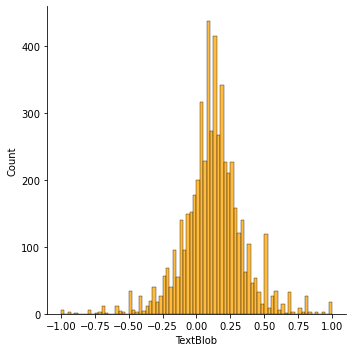

In [64]:
# plotting TextBlob Distribution for Good Advice
test = sample_df[sample_df['TextBlob'] != 0]
test2 = test[test['good_advice'] == 1]

sns.displot(x='TextBlob',data=test2, color='orange')

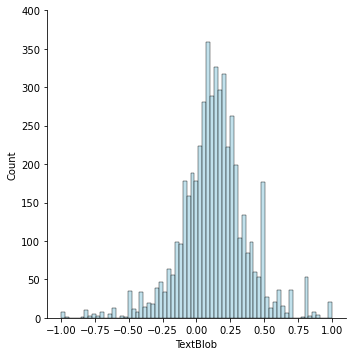

In [65]:
# plotting TextBlob Distribution for Not Good Advice
test3 = test[test['good_advice'] == 0]

g = sns.displot(x='TextBlob',data=test3, color='lightblue')

g = g.set(ylim=(0,400))
plt.show(g)

Unfortunately, qualitatively examining these distributions of the good and bad advice for the TextBlob sentiment scores show very similar qualities. In addition, comparing the distributions of the good and bad advice for the other features that we chose shows more of the same.

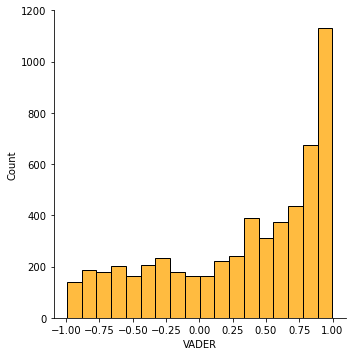

In [66]:
# plotting VADER Distribution for Good Advice
test = sample_df[sample_df['VADER'] != 0]
test2 = test[test['good_advice'] == 1]

g = sns.displot(x='VADER',data=test2, color='orange')
g = g.set(ylim=(0,1200))
plt.show(g)

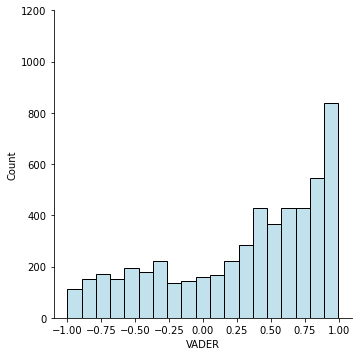

In [67]:
# plotting VADER Distribution for Not Good Advice
test3 = test[test['good_advice'] == 0]

g = sns.displot(x='VADER',data=test3, color='lightblue')
g = g.set(ylim=(0,1200))
plt.show(g)

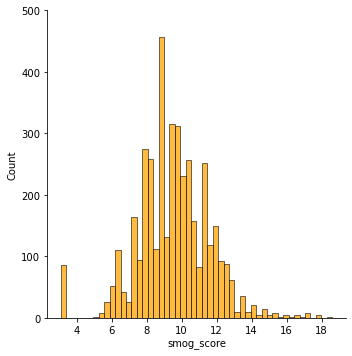

In [68]:
# plotting SMOG Distribution for Good Advice
test = sample_df[sample_df['smog_score'] != 0]
test2 = test[test['good_advice'] == 1]

g = sns.displot(x='smog_score',data=test2, color='orange')
g = g.set(ylim=(0, 500))
plt.show(g)

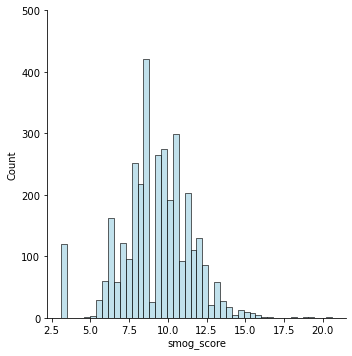

In [69]:
# plotting SMOG Distribution for Not Good Advice
test3 = test[test['good_advice'] == 0]

g = sns.displot(x='smog_score',data=test3, color='lightblue')
g = g.set(ylim=(0,500))
plt.show(g)

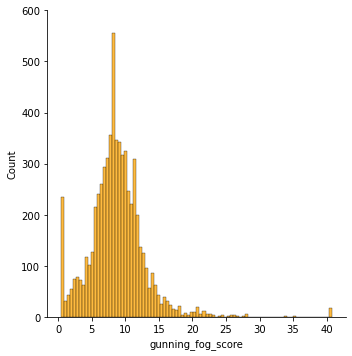

In [70]:
# plotting Gunning Fog Distribution for Good Advice
test = sample_df[sample_df['gunning_fog_score'] != 0]
test2 = test[test['good_advice'] == 1]

g = sns.displot(x='gunning_fog_score',data=test2, color='orange')
g = g.set(ylim=(0, 600))
plt.show(g)

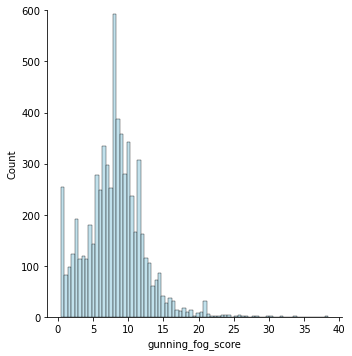

In [71]:
# plotting Gunning Fog Distribution for Not Good Advice
test3 = test[test['good_advice'] == 0]
test3 = test3[test3['gunning_fog_score'] < 40]

g = sns.displot(x='gunning_fog_score',data=test3, color='lightblue')
g = g.set(ylim=(0,600))
plt.show(g)

As we can see, the distributions between good and bad advice for each of the features that we chose were very similar. This will likely affect the strength of our models negatively.

## Part 7: Model 1 -  Naive Bayes

We will use naive bayes model and compare accuracy scores when just using metrics of our comments (length, sentiment, etc...) and also using the document-term matrix of our comments. This will also show us whether the actual words being used have a greater effect on 'good' advice.

First lets seperate our variable columns and our category column:

In [72]:
# seperating X and Y variables:
X = sample_df.drop(['good_advice'], axis = 1)
Y = sample_df['good_advice']
print(X.shape)
print(Y.shape)

(12882, 23986)
(12882,)


We will be using cross validation for to generate accuracy scores. We will use 10 folds for cross-validation:

In [73]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold

# using 10 folds
cv = StratifiedKFold(n_splits=10)

For our Naive Bayes model, we will use GaussianNB from sklearn. First I will try a model that includes our vectorized words (document-term matrix) to predict whether advice is good or not.

In [74]:
from sklearn.naive_bayes import GaussianNB

# initializing Naive Bayes
naivebayes = GaussianNB()
# passing our document-term matrix + metrics:
results = cross_validate(naivebayes, X, Y.values, cv = cv, return_train_score=True)
# generating our average test score and printing
nb_score = results['test_score'].mean()
print("Naive Bayes Score:", nb_score)

Naive Bayes Score: 0.6237521623483946


Our Test Score from 10 folds averages at ~62%. We can also compare it to the training score:

In [75]:
print("Naive Bayes Test Score:", nb_score)
nb_train = results['train_score'].mean()
print("Naive Bayes Train Score:",nb_train)

Naive Bayes Test Score: 0.6237521623483946
Naive Bayes Train Score: 0.8071385522730645


As expected the training score is higher than the testing score, by around 18%. Now lets compare it to a model that uses only our metrics (length, sentiments, reading level, etc...):

In [76]:
# only using metrics
X_only_metrics = sample_df.iloc[:, 23980:23986]
# running NB using only metrics
only_metric_results = cross_validate(naivebayes, X_only_metrics, Y.values, cv = cv, return_train_score=True)
# storing our results from x-validation
metric_test = only_metric_results['test_score'].mean()
metric_train = only_metric_results['train_score'].mean()

We will also check how each metric individually scores:

In [77]:
# checking how individual metrics predict
metric_names = ['TextBlob', 'VADER', 'Stopword Ratio', 'Length', 'SMOG', 'FOG']
metric_scores = []
metric_err = []
# running a NB for each metric and storing the results
for i in range(6):
    temp_results = cross_validate(naivebayes, X_only_metrics.iloc[:, i].values.reshape(-1, 1),
               Y.values, cv = cv, return_train_score=True)
    metric_scores.append(temp_results['test_score'].mean())
    metric_err.append(temp_results['test_score'].std())

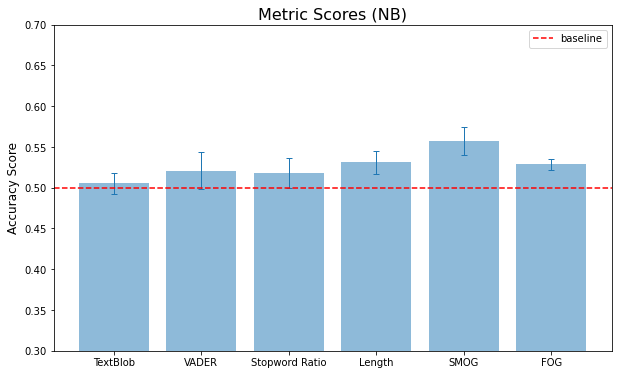

In [78]:
# plotting how each individual metric performs
plt.rcParams['figure.figsize'] = [10, 6]

plt.bar(metric_names, metric_scores, yerr=metric_err, alpha = 0.5, 
        error_kw=dict(ecolor='#1f77b4', lw=1, capsize=3, capthick=1))
plt.title("Metric Scores (NB)", size=16)
plt.ylabel("Accuracy Score", size = 12)
plt.axhline(0.5, linestyle='--', color='red', label='baseline')
plt.legend()
plt.ylim(0.3, 0.7)
plt.show()

The plot above shows how each individual metric scores in a naive bayes model to predict good advice. The baseline is 50% performance. We can see that TextBlob polarity alone perfomed the worse, and most similar to baseline. In contrast SMOG, gunning-fog, and Length were the best. However alone all these metrics barely performed much better (~55%) at best. We can compare our bag-of-words to the metrics alone:

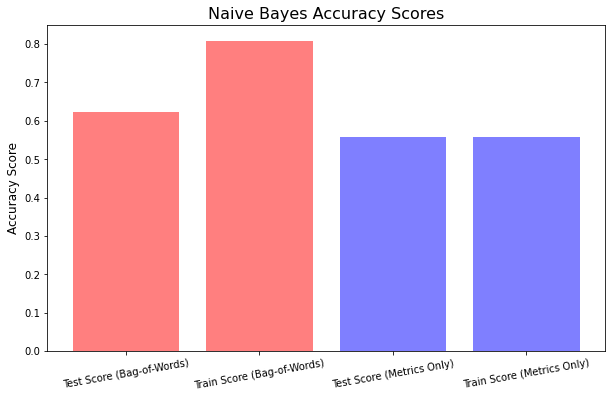

In [79]:
plt.rcParams['figure.figsize'] = [10, 6]
scores_list = [nb_score, nb_train, metric_test, metric_train]
scores_name = ['Test Score (Bag-of-Words)', 'Train Score (Bag-of-Words)', 
               'Test Score (Metrics Only)', 'Train Score (Metrics Only)']

plt.bar(scores_name, scores_list, alpha = 0.5, color=['red', 'red', 'blue', 'blue'])
plt.xticks(rotation = 10)
plt.ylim(0, 0.85)
plt.title("Naive Bayes Accuracy Scores", size=16)
plt.ylabel("Accuracy Score", size = 12)
plt.show()

From the graph above, we can see that using words had a better prediction rate than metrics alone. Still our test score for bag of words was only about 62% accurate. This indicates that good advice can only marginally be predicted alone from annotated text metrics. The actual choice of words matter more, but still does not tell the entire story. I suspect some of the limitations in our findings could be due to a handful of reasons. First, we did not consider every possible metric. Other important metrics to consider could have been Parts of Speech (POS) percentage or ratio of punctuation. SMOG was our best measured metric, which indicates that writing level is more indicative of advice quality than necessarily Sentiments. Another limitation could have been how we partitioned our good and not-good advice. We used a slighty arbitrary cut off based on upvote score, where the top 25% of scored comments of a submission were 'good' advice. This means that jokes with high upvotes could have been interpretted as good advice even if it was not. 

## Part 8: Model 2 - Logistic Regression

For each metric, fit a logistic regression model to see which metrics are the best indicators of good advice.

In [80]:
sample0 = ml_df[ml_df['good_advice'] == 0].sample(n=6441, random_state=7)
sample1 = ml_df[ml_df['good_advice'] == 1]
metrics_sample = pd.concat([sample0, sample1])
metrics_sample.head()

,body,TextBlob,VADER,stopword_ratio,body_length,smog_score,gunning_fog_score,good_advice,cleaned_text
10570,Yes.,0.000000,0.4019,0.000000,2,0.0,0.40,0,yes
1168,"Isn’t there a book on how to be genderless, se...",0.000000,0.0000,0.421053,19,0.0,16.67,0,book genderless secular unpolitical organism m...
12321,I currently work on the analytics side of e-co...,0.147449,0.9711,0.391813,171,11.0,10.88,0,currently work analytics side ecommerceretail ...
6045,Interstate/International Truck Driver. My rela...,0.329167,0.9077,0.413793,87,11.2,11.90,0,interstateinternational truck driver relative ...
19302,It's not you being able to not picture yoursel...,0.245000,0.9286,0.415254,118,8.0,6.95,0,able picture somewhere way job advertisement w...


In [81]:
import statsmodels.api as sm
# logistic regression using TextBlob polarity score
X = metrics_sample.TextBlob
y = metrics_sample.good_advice
logit1 = sm.Logit(y,X)
result = logit1.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: good_advice      AIC:              17860.2364
Date:               2022-06-01 23:06 BIC:              17867.7000
No. Observations:   12882            Log-Likelihood:   -8929.1   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     2.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
TextBlob   -0.0063     0.0725   -0.0869   0.9307   -0.1485   0.1359



In [82]:
# logistic regression using VADER polarity score
X = metrics_sample.VADER
y = metrics_sample.good_advice
logit2 = sm.Logit(y,X)
result = logit2.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.692895
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: good_advice      AIC:              17853.7543
Date:               2022-06-01 23:06 BIC:              17861.2179
No. Observations:   12882            Log-Likelihood:   -8925.9   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     3.0000                                       
--------------------------------------------------------------------
          Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
VADER     0.0736      0.0289    2.5469    0.0109    0.0170    0.1303



In [83]:
# logistic regression using stopword ratio
X = metrics_sample.stopword_ratio
y = metrics_sample.good_advice
logit3 = sm.Logit(y,X)
result = logit3.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: good_advice      AIC:              17859.5888
Date:               2022-06-01 23:06 BIC:              17867.0524
No. Observations:   12882            Log-Likelihood:   -8928.8   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     3.0000                                       
------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
stopword_ratio   0.0368    0.0455  0.8094  0.4183  -0.0523  0.1259



In [84]:
# logistic regression using length of text
X = metrics_sample.body_length
y = metrics_sample.good_advice
logit4 = sm.Logit(y,X)
result = logit4.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.689856
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.005     
Dependent Variable: good_advice      AIC:              17775.4445
Date:               2022-06-01 23:06 BIC:              17782.9081
No. Observations:   12882            Log-Likelihood:   -8886.7   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
body_length   0.0014     0.0002   9.0174   0.0000   0.0011   0.0017



In [85]:
# logistic regression using SMOG score
X = metrics_sample.smog_score
y = metrics_sample.good_advice
logit5 = sm.Logit(y,X)
result = logit5.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.690106
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.004     
Dependent Variable: good_advice      AIC:              17781.9000
Date:               2022-06-01 23:06 BIC:              17789.3636
No. Observations:   12882            Log-Likelihood:   -8889.9   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     3.0000                                       
-------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
smog_score    0.0213     0.0024   8.8235   0.0000   0.0166   0.0260



In [86]:
# logistic regression using gunning fog score
X = metrics_sample.gunning_fog_score
y = metrics_sample.good_advice
logit6 = sm.Logit(y,X)
result = logit6.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: good_advice      AIC:              17856.0733
Date:               2022-06-01 23:06 BIC:              17863.5369
No. Observations:   12882            Log-Likelihood:   -8927.0   
Df Model:           0                LL-Null:          -8929.1   
Df Residuals:       12881            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     3.0000                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
gunning_fog_score     0.0036   0.0018 2.0377 0.0416 0.0001 0.0071



For all of the logistic regression models with a single independent variable, the pseudo r-squared value is close to 0 and the log-likelihood values are large and negative (approx. -8900), which indicates that these models have little predictive power and a logistic model is unlikely to be a good fit.

In [87]:
# use all metrics as features for multiple logistic regression
X = metrics_sample.iloc[:, 1:7]
y = metrics_sample.good_advice
logit7 = sm.Logit(y,X)
result = logit7.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.685372
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.011     
Dependent Variable: good_advice      AIC:              17669.9143
Date:               2022-06-01 23:06 BIC:              17714.6958
No. Observations:   12882            Log-Likelihood:   -8829.0   
Df Model:           5                LL-Null:          -8929.1   
Df Residuals:       12876            LLR p-value:      2.4148e-41
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
TextBlob          -0.0424   0.0902 -0.4705 0.6380 -0.2192  0.1343
VADER             -0.0344   0.0374 -0.9193 0.3580 -0.1078  0.0390


Even a multiple logistic regression model which combines all of the sentiment and readability metrics is only a slight improvement on the performance of the single-variable logistic models.

## Part 9: Hypothesis Testing:

From our Naive Bayes Model we observed that Readability Scores (SMOG/FOG) and Body length were the metrics that created the best model when used in isolation. To see exactly what qualities these traits have on advice, we wanted to compare means and use hypothesis testing.

First, We want to see what the difference in mean SMOG scores are between good and not good advice. We can then use T-Test to see if this average difference in signifcant:

Text(0.5, 0, 'Advice Category')

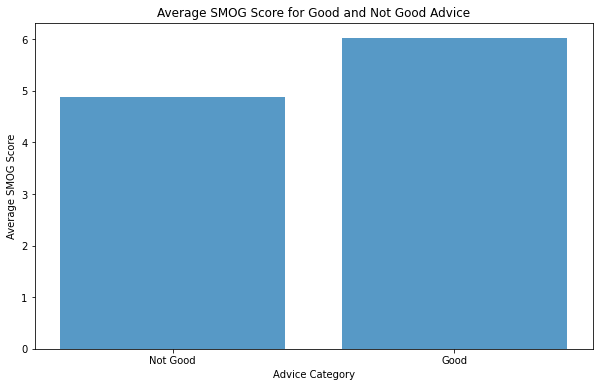

In [88]:
# dataframe containing our metrics and good advice column
ttest_df = sample_df.iloc[:, 23980:23987]
# retrieving mean SMOG score for good and bad advice
bad_smog, good_smog = ttest_df.groupby('good_advice').smog_score.mean()
# plotting it as a bar
plt.bar(['Not Good', "Good"], [bad_smog, good_smog],alpha = 0.75)
plt.title('Average SMOG Score for Good and Not Good Advice')
plt.ylabel("Average SMOG Score")
plt.xlabel("Advice Category")

The average SMOG score for good advice is 6.0, whereas other comments are 4.87. That means good advice seems to have a higher average readbility (SMOG) score than not good advice. This means our NB model from above may factor better written posts as metric for good advice. To see whether this difference in means is signifcant we will do a T-Test:

In [89]:
# we can use scipy for T-Test
import scipy.stats as stats
stats.ttest_ind(ttest_df[ttest_df['good_advice'] == 0]['smog_score'],
                ttest_df[ttest_df['good_advice'] == 1]['smog_score'])

Ttest_indResult(statistic=-13.28670430657655, pvalue=5.069471679861382e-40)

The T-Test above compares the average SMOG score for good and not good advice comments. Our p-value is 5.07e-40, which is highly signficant! That means SMOG reability index is a reliable metric than can be used to differentiate good and bad advice. The other metric from our Naive Bayes that was interesting was body length. Lets repeat this process to see body length variations:

Text(0.5, 0, 'Advice Category')

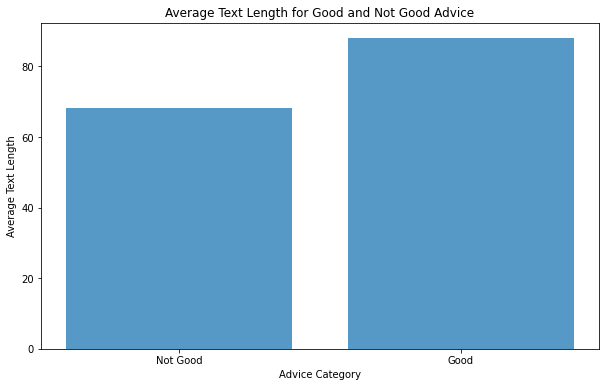

In [90]:
# retrieving mean body length score for good and bad advice
bad_len, good_len = ttest_df.groupby('good_advice').body_length.mean()
# plotting it as a bar
plt.bar(['Not Good', "Good"], [bad_len, good_len],alpha = 0.75)
plt.title('Average Text Length for Good and Not Good Advice')
plt.ylabel("Average Text Length")
plt.xlabel("Advice Category")

The Average good advice comment is longer on average (88 tokens) than other comments (68 tokens), by 20 words. Let's see if this difference is statistically signficant:

In [91]:
stats.ttest_ind(ttest_df[ttest_df['good_advice'] == 0]['body_length'],
                ttest_df[ttest_df['good_advice'] == 1]['body_length'])

Ttest_indResult(statistic=-11.941416493178453, pvalue=1.0709980883200153e-32)

Again, we see a highly signifcant p-value! This means that good advice is typically longer than not good advice. This makes sense along with readability. We expect good advice comments to be well written (higher readibility) and also to be detailed. This may mean that it has longer sentences in general.

## Part 10: Takeaways

From our topic modeling of the submissions in each of these subreddits, we were able to identify distinct communities. Some of the topics we were able to identify taught us that many marginalized communities use these subreddits to get information about work and hiring that they would otherwise not get access to. One example of this is the distinct topic around previously-incarcerated people. Previously-incarcerated people historically have an extremely difficult time reaclimating themselves in the working world, and having access to reliable and proven advice from these subreddits can be life-changing. 

From our topic analysis, we could recommend that companies identify the topics that these marginalized groups are most commonly asking about, and making access to this information more readily and easily available.

From our comment characterization, our models had ambigious results. We did find that out of the features that we chose, body length and readability were the two most important factors in predicting good advice. From T-Test validation, we see that people who take the time to write out longer and well-written responses also generally give better advice. In addition, our bag-of-words models performed better than the models of our chosen features, which indicates that the content of the comment is more important than other charactertistics of it (like sentiment or stopword ratio). This would require additional research in the future.

## Part 11: Limitations, Ethics, and Future Work

### Limitations

One limitation in our study was that we only studied posts in the English language, which inherently biases our data toward work problems that are primarily experienced by English-speakers. Even if the scope of our research is narrowed to only characterize the workplace problems of US workers, there are still large portions of the population that are left out by us not including other languages.

Another limitation in our study was that we only collected data from Reddit. This could bias our findings in more than one way. First, the unique culture that is cultivated within certain subreddits could lead us to misunderstand and miscategorize comments. For example, in some subreddits, inside jokes could start to form, which could skew data about topic modeling. Another way our findings could be biased because our lack of cross-platform investigation is that we only identify problems that people are comfortable posting about online. There may be many different kinds of workplace problems that people face that are underrepresented in our data because they may involve sensitive or private information that someone wouldn’t want to share to an online community of hundreds of thousands of people.When we collected the Reddit data, we did not collect for awards, which also limited the scope for how to verify advice relevancy. 

One final limitation to our study was that we lacked the people-power to effectively verify our models. Because we couldn’t look through tens of thousands of comments in the time frame for this project, we had to use other metrics to try to measure “good” advice on these platforms. However, this is much more inaccurate and less reliable than manually coding each comment.


### Ethical Considerations

One thing to consider for this research as far as ethics is the data collection method. We collected Reddit comments and submissions without the informed consent of the posters or moderators of the subreddits. However, we found this morally permissible because this research is not meant to be published, and we did not take steps to further deanonymize the data more than what was already publicly available information. Future work, however, should take this into consideration, especially if there are plans to publish the research or make the data set widely available.

Another thing to consider for our research is the scope. Because we only studied English posts from Reddit, our data is inherently biased, so we have to be extremely careful not to overgeneralize our findings. If we do overgeneralize our findings, we can make incorrect assumptions about populations, which could have widespread negative effects if future research is made more public.

 

### Future Work

Fully-funded versions of this work could hire Mechanical Turks to manually code “good” advice. As mentioned in the “Limitations” section, we had to rely on comment score to measure “good” advice, but that ended up being a relatively unreliable metric. Having people manually code what constitutes good advice, giving them a strict rubric to follow, could lead to more reliable results in the future.

We could also do a lot to diversify our data set. We could include other job-advice platforms outside of Reddit, as well as non-English platforms with the hiring of reliable translators. Expanding our data set would allow us to learn more about the workplace as a whole and generalize the findings of our research to a much wider audience.

Future research in this area would also explore more features for our data. The features that we examined in this research were not very strongly correlated to the quality of advice (or at least our measure of it), so in future research, we could look at more features that might have stronger relationships.


### Team Member Contributions:

**Wen Yi**:

- Post Collection/Reddit API (Seperate Notebook)
- EDA/Preliminary Analysis
- Logistic Regression

**Walker**:

- LDA Topic Modelling (Seperate Notebook)
- Comment Collection (Seperate Notebook)
- Score Seperation
- Naive Bayes
- Hypothesis Testing (T-Tests)

**Ken**:

- Notebook/Code Compilation
- EDA/Preliminary Analysis
- Metric Distribution Visualization
- Limitations/Ethics/Future Work write up